# Run The Agent on Mountain Car

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [3]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [4]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [5]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [6]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20])
dec = create_decoder(latent_dim, 2, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=False)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # # make the HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, output_dim=1, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

In [9]:
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=True,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=True,
                           habit_model_type="PG",
                           uncertainty_tolerance=0.1,
                           min_rewards_needed_to_train_prior=-10,
                           prior_model_scaling_factor=0.01)


daifa.train_prior = True
daifa.prior_model.show_training = False

In [10]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1
[-0.43956137  0.        ]
fast thinking
training on full data
0 25
Success in episode 1 at time step 150 with reward 98.46780469437122
Episode 2
[-0.4347016  0.       ]
fast thinking
fast thinking
training on full data
1 32
Success in episode 2 at time step 189 with reward 97.73705899581833
Episode 3
[-0.52595973  0.        ]
fast thinking
fast thinking
fast thinking
training on full data
2 100
Success in episode 3 at time step 598 with reward 92.1587861019004
Episode 4
[-0.52681816  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
3 40
Success in episode 4 at time step 238 with reward 96.81496597452293
Episode 5
[-0.41335943  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
6 25
Success in episode 5 at time step 150 with reward 98.3755242452271
Episode 6
[-0.48689285  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast

In [12]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.292491,234,39
1,99.370224,228,38
2,99.572642,162,27
3,99.493669,156,26
4,99.595729,156,26
5,99.451079,234,39
6,99.496206,198,33
7,99.189146,234,39
8,99.315176,240,40
9,99.581468,162,27


In [13]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [14]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.5020741  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
7 25
Success in episode 1 at time step 148 with reward 98.54000042502663
Episode 2
[-0.5301094  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
19 30
Success in episode 2 at time step 179 with reward 98.97352552476165
Episode 3
[-0.58398724  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
11 26
Success in episode 3 at time step 154 with reward 98.60503098008607
Episode 4
[-0.47200945  0.        ]
fast thinking

In [15]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [16]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.441804,156,26
1,98.946127,216,36
2,99.343316,186,31
3,99.373279,156,26
4,99.234800,144,24
5,99.302210,150,25
6,99.458742,192,32
7,99.414936,156,26
8,99.315925,180,30
9,99.437593,252,42


In [17]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.5216806  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
15 27
Success in episode 1 at time step 158 with reward 98.68964613769884
Episode 2
[-0.5691545  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
14 26
Success in episode 2 at time step 152 with reward 98.64146526340903
Episode 3
[-0.54602736  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
9 24
Success in episode 3 at time step 143 with reward 98.4387655103888
Episode 4
[-0.54004896  0.        ]


In [18]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,98.948101,216,36
1,99.322918,150,25
2,99.156730,174,29
3,99.161385,144,24
4,99.172691,192,32
5,99.297761,150,25
6,99.405666,156,26
7,99.400808,150,25
8,99.353511,216,36
9,99.219082,144,24


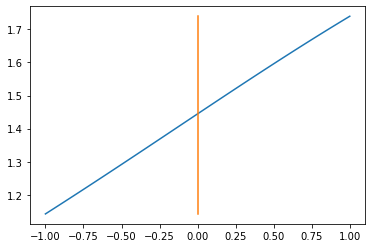

In [19]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

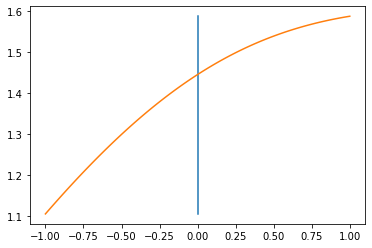

In [20]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

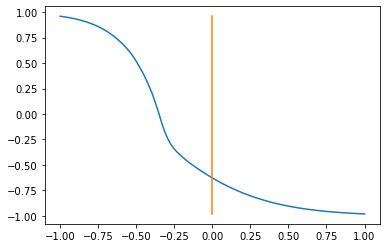

In [21]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

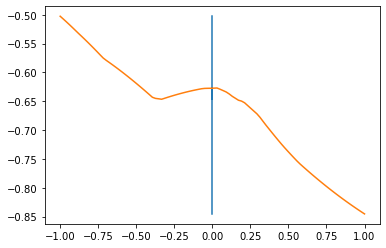

In [22]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [23]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,99.147007,144,24
1,99.145524,144,24
2,99.028627,246,41
3,99.150402,144,24
4,99.377241,156,26


In [24]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.44333583  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
12 23
Success in episode 1 at time step 137 with reward 98.95115726664957
Episode 2
[-0.4032618  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
10 23
Success in episode 2 at time step 136 with reward 98.78116440685915
Episode 3
[-0.47036394  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
7 15
Success in episode 3 at time step 88 with reward 99.1920493660615
Episode 4
[-0.42520484  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking

In [27]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.284963,144,24
1,99.365301,162,27
2,98.931635,180,30
3,99.135315,174,29
4,99.067052,144,24
5,99.039758,144,24
6,98.748875,210,35
7,99.441092,150,25
8,99.147505,210,35
9,99.407831,156,26


In [23]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

Episode 1
[-0.5224015  0.       ]
fast thinking
training on full data
0 167
No Success
Episode 2
[-0.43721193  0.        ]
fast thinking
training on full data
0 167
No Success
Episode 3
[-0.4992093  0.       ]
fast thinking
training on full data
0 167
No Success
Episode 4
[-0.5301187  0.       ]
fast thinking
training on full data
0 167
No Success
Episode 5
[-0.569877  0.      ]
fast thinking
training on full data
0 167
No Success
Episode 6
[-0.4889871  0.       ]
fast thinking
training on full data
0 167
No Success
Episode 7
[-0.43800998  0.        ]
fast thinking
training on full data
0 167
No Success
Episode 8
[-0.43729874  0.        ]
fast thinking
training on full data
0 167
No Success
Episode 9
[-0.55293274  0.        ]
fast thinking
training on full data
0 167
No Success
Episode 10
[-0.5700398  0.       ]
fast thinking
training on full data
0 167
No Success
Episode 11
[-0.5193584  0.       ]
fast thinking
training on full data
0 167
No Success
Episode 12
[-0.4146968  0.       ]


In [28]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.072127,138,23
1,99.064519,144,24
2,99.216836,150,25
3,99.364943,150,25
4,99.429507,150,25
5,99.120388,174,29
6,99.115241,204,34
7,99.189887,180,30
8,99.236570,150,25
9,99.115621,192,32


In [30]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,99.220475,192,32
1,99.348595,144,24
2,98.599894,216,36
3,99.342812,150,25


In [31]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

,episode,success,sim_steps,VFE_post_run,noise_stddev,percent_use_fast_thinking,total_reward,agent_time_ratio
0,0,True,150,57.739182,"[0.05, 0.05]",0.000000,98.467805,6
1,1,True,189,121.687241,"[0.05, 0.05]",0.031250,97.737059,6
2,2,True,598,64.508942,"[0.05, 0.05]",0.020000,92.158786,6
3,3,True,238,61.143745,"[0.05, 0.05]",0.075000,96.814966,6
4,4,True,150,52.172348,"[0.05, 0.05]",0.240000,98.375524,6
...,...,...,...,...,...,...,...,...
45,45,True,154,10.972008,"[0.05, 0.05]",0.423077,98.165087,6
46,46,True,78,8.098291,"[0.05, 0.05]",0.307692,99.189286,6
47,47,True,144,8.839088,"[0.05, 0.05]",0.458333,98.688832,6
48,48,True,161,11.128732,"[0.05, 0.05]",0.370370,98.233315,6


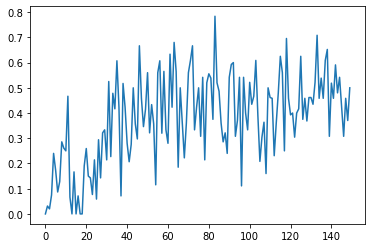

In [32]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

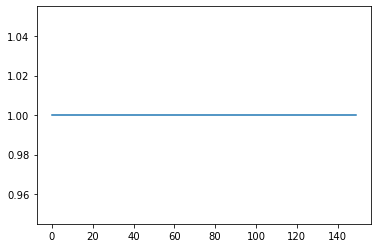

In [33]:
plt.plot(T, full_results.success)

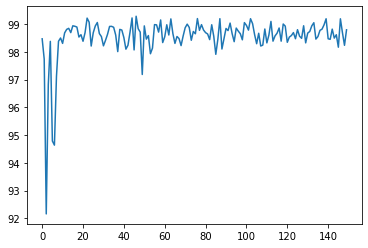

In [34]:
plt.plot(T, full_results.total_reward)

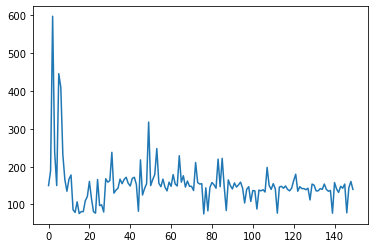

In [35]:
plt.plot(T, full_results.sim_steps)